<a href="https://colab.research.google.com/github/mneochengrustno/Works/blob/main/Graphs7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задача о назначениях**

### 1. Вспомогательные функции

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#функция для работы с вычитаниями в матрице
def zeros_bipartite_adj(mat, tol=1e-9):
    n = mat.shape[0]
    adj = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if abs(mat[i,j]) < tol:
                adj[i].append(j)
    return adj

#функция для отображения двудольного графа по нулевым ребрам
def draw_bipartite_graph_from_adj(adj, match_v=None, rows_covered=None, cols_covered=None, title=None):
    n = len(adj)
    G = nx.Graph()
    left = [f'v{i+1}' for i in range(n)]
    right = [f'w{j+1}' for j in range(n)]
    G.add_nodes_from(left, bipartite=0)
    G.add_nodes_from(right, bipartite=1)
    edges = []
    for i in range(n):
        for j in adj[i]:
            edges.append((f'v{i+1}', f'w{j+1}'))
            G.add_edge(f'v{i+1}', f'w{j+1}')
    pos = {f'v{i+1}': (0, -i) for i in range(n)}
    pos.update({f'w{j+1}': (3, -j) for j in range(n)})
    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(G, pos, nodelist=left+right, node_color='lightgray', node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=9)
    if edges:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black', width=1)
    if match_v is not None:
        matched_edges = []
        for i, j in enumerate(match_v):
            if j != -1:
                matched_edges.append((f'v{i+1}', f'w{j+1}'))
        if matched_edges:
            nx.draw_networkx_edges(G, pos, edgelist=matched_edges, edge_color='red', width=2.5)
    if rows_covered is not None:
        covered_left = [f'v{i+1}' for i,b in enumerate(rows_covered) if b]
        if covered_left:
            nx.draw_networkx_nodes(G, pos, nodelist=covered_left, node_color='lightblue', node_size=700)
    if cols_covered is not None:
        covered_right = [f'w{j+1}' for j,b in enumerate(cols_covered) if b]
        if covered_right:
            nx.draw_networkx_nodes(G, pos, nodelist=covered_right, node_color='lightblue', node_size=700)
    plt.title(title or 'G')
    plt.axis('off')
    plt.show()

In [ ]:
 vnv

### 2. Реализация алгоритма А и алгоритма В

In [ ]:
#алгоритм А
def algorithm_A(adj):
    n = len(adj)
    match_v = [-1] * n
    match_w = [-1] * n
    def dfs(v, visited):
        for w in adj[v]:
            if visited[w]:
                continue
            visited[w] = True
            if match_w[w] == -1 or dfs(match_w[w], visited):
                match_v[v] = w
                match_w[w] = v
                return True
        return False
    for v in range(n):
        visited = [False] * n
        dfs(v, visited)
    pairs = [(f'v{i+1}', f'w{match_v[i]+1}') for i in range(n) if match_v[i] != -1]
    return match_v, match_w, pairs

In [ ]:
#покрывающие линии
def min_lines_cover_from_adj(adj, match_v, match_w):
    n = len(adj)
    unmatched_left = [i for i in range(n) if match_v[i] == -1]
    visited_left = [False] * n
    visited_right = [False] * n
    stack = unmatched_left[:]
    while stack:
        v = stack.pop()
        if visited_left[v]:
            continue
        visited_left[v] = True
        for w in adj[v]:
            if not visited_right[w]:
                visited_right[w] = True
                if match_w[w] != -1 and not visited_left[match_w[w]]:
                    stack.append(match_w[w])
    rows_covered = [not visited_left[i] for i in range(n)]
    cols_covered = [visited_right[j] for j in range(n)]
    return rows_covered, cols_covered

#функция для модификаций матрицы на итерации алгоритма B
def apply_modifier(mat, rows_cov, cols_cov):
    n = mat.shape[0]
    uncovered_vals = []
    for i in range(n):
        for j in range(n):
            if (not rows_cov[i]) and (not cols_cov[j]):
                uncovered_vals.append(mat[i,j])
    d = min(uncovered_vals) if uncovered_vals else 0.0
    m = mat.copy().astype(float)
    for i in range(n):
        for j in range(n):
            if (not rows_cov[i]) and (not cols_cov[j]):
                m[i,j] -= d
            elif rows_cov[i] and cols_cov[j]:
                m[i,j] += d
    return m, d

In [ ]:
#алгоритм B
def algorithm_B(cost_matrix, show_steps=True):
    n = cost_matrix.shape[0]
    mat = cost_matrix.astype(float)
    if show_steps:
        print("Исходная матрица:")
        print(cost_matrix)
    row_mins = mat.min(axis=1)
    mat = mat - row_mins[:, None]
    if show_steps:
        print("После вычитания минимума по строкам:")
        print(mat)
    col_mins = mat.min(axis=0)
    mat = mat - col_mins
    if show_steps:
        print("После вычитания минимума по столбцам:")
        print(mat)
    iteration = 0
    while True:
        iteration += 1
        if show_steps:
            print(f"\n--- Итерация {iteration} ---")
        adj = zeros_bipartite_adj(mat)
        if show_steps:
            draw_bipartite_graph_from_adj(adj, match_v=None, title=f'Нулевые рёбра (итерация {iteration})')
        match_v, match_w, pairs = algorithm_A(adj)
        if show_steps:
            print("Паросочетание:", pairs)
            draw_bipartite_graph_from_adj(adj, match_v=match_v, title=f'Паросочетание (итерация {iteration})')
        if sum(1 for x in match_v if x != -1) == n:
            assignment = [(f'v{i+1}', f'w{match_v[i]+1}') for i in range(n)]
            total_cost = sum(cost_matrix[i,j] for i,j in [(i-1,j-1) for i,j in [(int(v[1:]), int(w[1:])) for v,w in assignment]])
            if show_steps:
                print("\nСовершенное паросочетание найдено:", assignment)
                print("Минимальная суммарная стоимость:", total_cost)
                draw_bipartite_graph_from_adj(adj, match_v=match_v, title='Итоговое совершенное паросочетание')
            return assignment, total_cost
        rows_cov, cols_cov = min_lines_cover_from_adj(adj, match_v, match_w)
        if show_steps:
            print("Покрывающие строки:", rows_cov)
            print("Покрывающие столбцы:", cols_cov)
            draw_bipartite_graph_from_adj(adj, match_v=match_v, rows_covered=rows_cov, cols_covered=cols_cov,
                                          title=f'Покрывающие строки/столбцы (итерация {iteration})')
        mat, d = apply_modifier(mat, rows_cov, cols_cov)
        if show_steps:
            print(f"d = {d}")
            print("Новая матрица")
            print(mat)

### 3. Решение задачи о назначениях (вариант 23)

Исходная матрица:
[[9. 8. 9. 5. 9.]
 [1. 6. 1. 5. 9.]
 [6. 7. 3. 9. 2.]
 [2. 9. 3. 8. 1.]
 [3. 4. 7. 7. 6.]]
После вычитания минимума по строкам:
[[4. 3. 4. 0. 4.]
 [0. 5. 0. 4. 8.]
 [4. 5. 1. 7. 0.]
 [1. 8. 2. 7. 0.]
 [0. 1. 4. 4. 3.]]
После вычитания минимума по столбцам:
[[4. 2. 4. 0. 4.]
 [0. 4. 0. 4. 8.]
 [4. 4. 1. 7. 0.]
 [1. 7. 2. 7. 0.]
 [0. 0. 4. 4. 3.]]

--- Итерация 1 ---


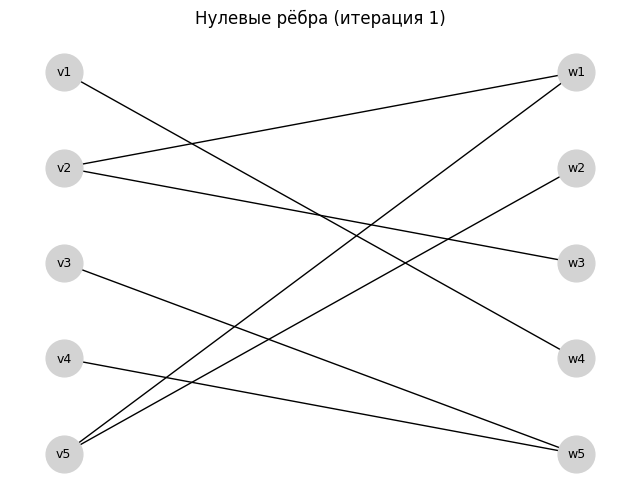

Паросочетание: [('v1', 'w4'), ('v2', 'w3'), ('v3', 'w5'), ('v5', 'w1')]


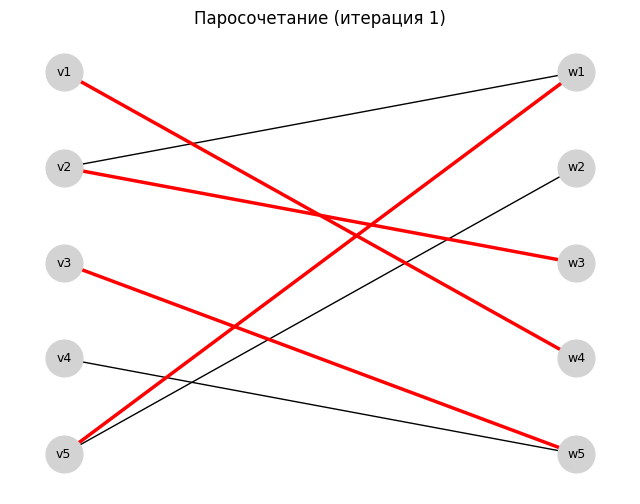

Покрывающие строки: [True, True, False, False, True]
Покрывающие столбцы: [False, False, False, False, True]


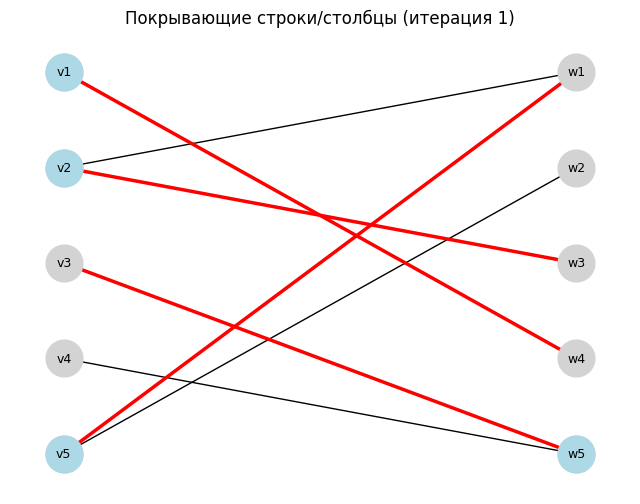

d = 1.0
Новая матрица
[[4. 2. 4. 0. 5.]
 [0. 4. 0. 4. 9.]
 [3. 3. 0. 6. 0.]
 [0. 6. 1. 6. 0.]
 [0. 0. 4. 4. 4.]]

--- Итерация 2 ---


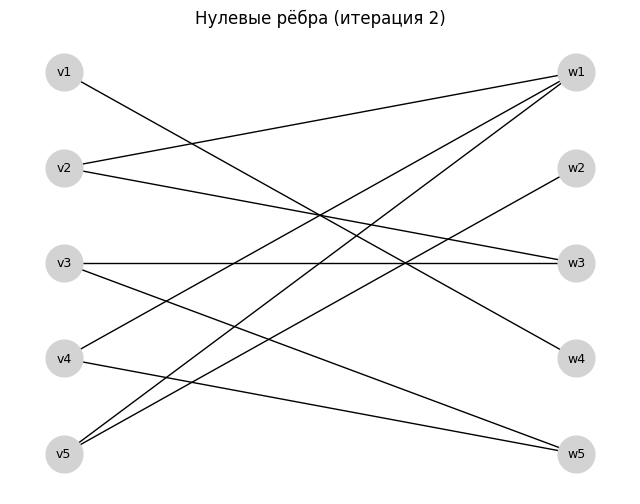

Паросочетание: [('v1', 'w4'), ('v2', 'w3'), ('v3', 'w5'), ('v4', 'w1'), ('v5', 'w2')]


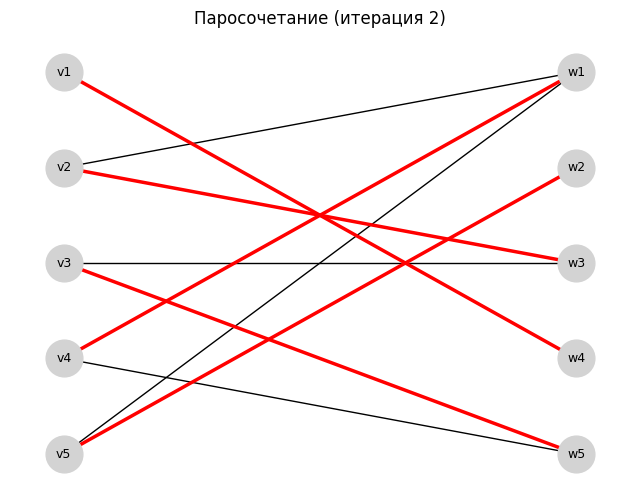


Совершенное паросочетание найдено: [('v1', 'w4'), ('v2', 'w3'), ('v3', 'w5'), ('v4', 'w1'), ('v5', 'w2')]
Минимальная суммарная стоимость: 14.0


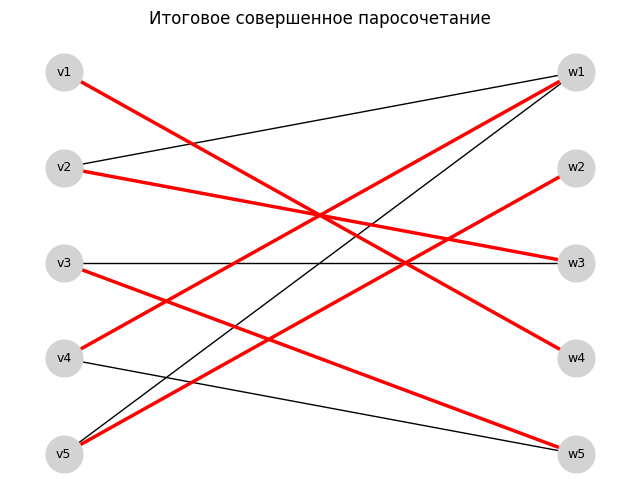


Результат: [('v1', 'w4'), ('v2', 'w3'), ('v3', 'w5'), ('v4', 'w1'), ('v5', 'w2')]
Оптимальный вес работ: 14.0


In [ ]:
A = np.array([
    [9, 8, 9, 5, 9],
    [1, 6, 1, 5, 9],
    [6, 7, 3, 9, 2],
    [2, 9, 3, 8, 1],
    [3, 4, 7, 7, 6]
], dtype=float)

assignment, cost = algorithm_B(A, show_steps=True)
print("\nРезультат:", assignment)
print("Оптимальный вес работ:", cost)